In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pytorch_ssim
# https://github.com/Po-Hsun-Su/pytorch-ssim
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 选择 dataset
batch_size = 10
eps = 0.3
step_size = 0.2
iteration = 10
K = 0.05

In [3]:
def filter_state_dict(state_dict):
    from collections import OrderedDict

    if 'state_dict' in state_dict.keys():
        state_dict = state_dict['state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if 'sub_block' in k:
            continue
        if 'module' in k:
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST("data_FashionMNIST", train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
from small_cnn import SmallCNN
model = SmallCNN()
#check_point = torch.load("pretrained_model/MNIST_small_cnn.checkpoint", map_location=torch.device(device))
check_point = torch.load("FashionMNIST_small_cnn_10.checkpoint")
model.load_state_dict(check_point)
#model.load_state_dict(check_point['state_dict'])
model.to(device)

SmallCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (layer_one): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU(inplace=True)
  )
  (feature_extractor): Sequential(
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu4): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=1024, out_features=200, bias=True)
    (relu1): ReLU(inplace=True)
    (drop): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU(inplace=True)
    (fc3): Linear(in_features=200, o

In [5]:
# 显示一张图片（没有transpose)
def imshow(img, title):
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(img.cpu(),(1,2,0)))
    plt.title(title)
    plt.show()

In [6]:
# 并排左右显示两张图片（没有transpose)
def double_imshow(img1,img2,title1,title2):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 2),(0, 0))
    plt.imshow(np.transpose(img1.cpu(),(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(np.transpose(img2.cpu(), (1, 2, 0)))
    i2.set_title(title2)
    plt.show()


In [7]:
# savepath = "adv_images/SSIM, step_size = 0.15 eps = 0.3/"
# 并排左右显示三张图片（没有transpose)
def triple_imshow(img1, img2, img3, title1, title2, title3, figNum = 0):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 3),(0, 0))
    plt.imshow(np.transpose(img1.cpu(),(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 3), (0, 1))
    plt.imshow(np.transpose(img2.cpu(), (1, 2, 0)))
    i2.set_title(title2)
    i3 = plt.subplot2grid((1, 3), (0, 2))
    plt.imshow(np.transpose(img3.cpu(), (1, 2, 0)))
    i3.set_title(title3)
    # sp = savepath + "img" + str(figNum) + '.png'
    # plt.savefig(sp)
    plt.show()

In [8]:
# l2 Loss
def l2(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0.0
    for i in range(0,channel):
        for j in range(0,height):
            for k in range(0, width):
                total_dif += (img1[i][j][k].item()-img2[i][j][k].item()) ** 2
    return total_dif ** 0.5

In [9]:
# l1 Loss
def l1(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += abs(img1[i][j][k].item() - img2[i][j][k].item())
    return total_dif

In [10]:
# l0 Loss 计算差距<=0.01像素点的数目
def l0(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += 0 if abs(img1[i][j][k].item() - img2[i][j][k].item()) <= 0.01 else 1
    return total_dif

In [11]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, delta, y, images, lam):
        mask = torch.ones_like(x).scatter_(1, y.unsqueeze(1), 0.)
        rest = x[mask.bool()].view(x.size(0), x.size(1) - 1)
        xx = torch.tensor(range(x.size(0)))
        f = torch.nn.ReLU()
        return torch.mean(f(x[xx, y] - torch.max(rest, 1)[0] + K) + lam *(1 - (pytorch_ssim.ssim(images,images+delta))))
        #return torch.mean(f(x[xx, y] - torch.max(rest, 1)[0] + K) + lam *(eps + torch.max(delta)))

In [12]:
def PGD_attack_MyLoss(net, images, labels, eps, step_size):
    images = images.to(device)
    labels = labels.to(device)

    delta = torch.zeros(images.size()).to(device)  #变量求导
    lam = torch.zeros(1).to(device)
    #delta.uniform_(-eps, eps).to(device)
    delta = Variable(delta, requires_grad=True)
    lam = Variable(lam,requires_grad=True)
    # print(images.size())
    # print(labels.size())
    # ori_images = images.data
    criterion = My_loss()
    for i in range(iteration):
        # delta.requires_grad = True
        # lam.requires_grad = True
        # print(images.size())
        outputs = net(images + delta)
        net.zero_grad()
        loss = criterion(outputs, delta, labels,images,lam).to(device)
        loss.backward()

        # print(delta.grad)
        new_delta = delta - step_size * delta.grad.detach()
        adv_images = torch.clamp(images + new_delta, min=0, max=1)
        delta = adv_images - images
        new_lam = lam + step_size * lam.grad.detach()
        if new_lam < 0:
            lam = torch.zeros(1).to(device)
        else:
            lam = new_lam
        # delta = torch.clamp(delta, min=-eps, max=eps)
        delta = Variable(delta, requires_grad=True)
        lam = Variable(lam,requires_grad=True)
        # for i in range(0, images.size()[0]):
        #     print(torch.max(delta[i]).item())
        #     print(torch.min(delta[i]).item())
    deltas = []
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return images + delta, deltas

In [13]:
def PGD_attack_Conventional(model, image, label, eps, step_size, iters=10):
    image = image.to(device)
    label = label.to(device)
    loss = nn.NLLLoss()
    ori_image = image.data

    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()
        adv_image = image + step_size * image.grad.sign()
        delta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + delta, min=0, max=1).detach_()
    deltas = []
    delta = image-ori_image 
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return image ,deltas 

Total Image Count: 6 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.959 Conventional: 0.647
Total Image Count: 10 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.917 Conventional: 0.615
Total Image Count: 14 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.926 Conventional: 0.607
Total Image Count: 15 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.903 Conventional: 0.605
Total Image Count: 22 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.923 Conventional: 0.614
Total Image Count: 27 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.919 Conventional: 0.626
Total Image Count: 31 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.917 Conventional: 0.616
Total Image Count: 37 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0


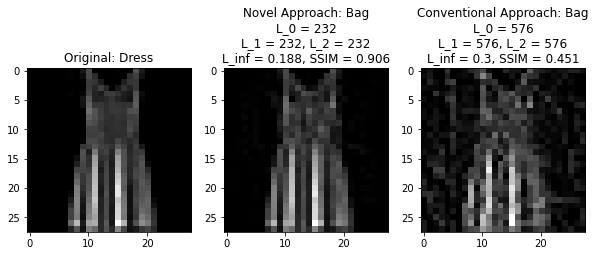

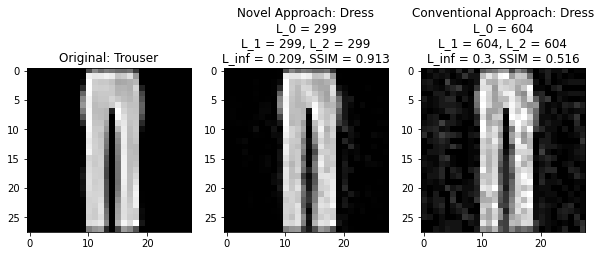

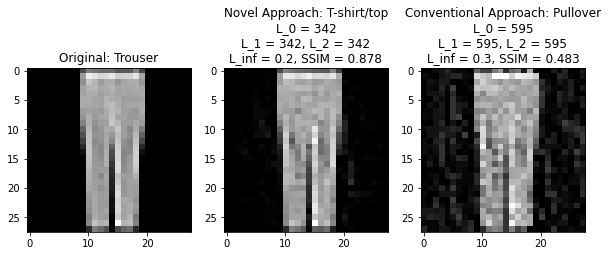

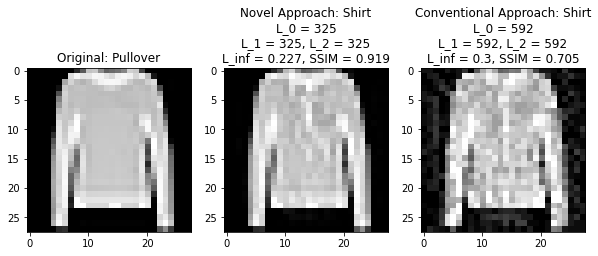

Total Image Count: 46 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.921 Conventional: 0.623
Total Image Count: 49 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.923 Conventional: 0.625
Total Image Count: 55 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.925 Conventional: 0.635
Total Image Count: 61 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.927 Conventional: 0.633
Total Image Count: 69 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.93 Conventional: 0.631
Total Image Count: 76 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.626
Total Image Count: 79 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.623
Total Image Count: 83 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0


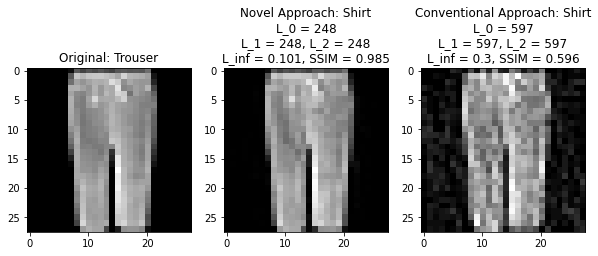

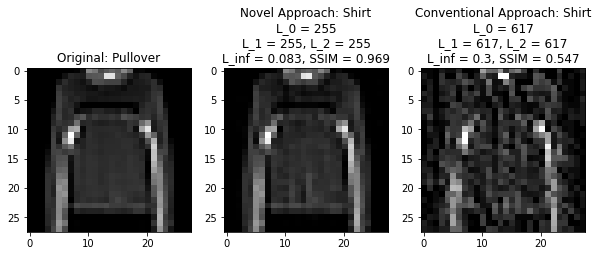

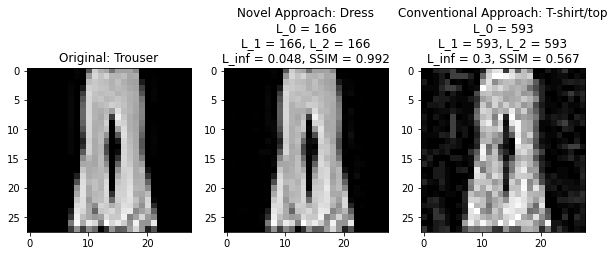

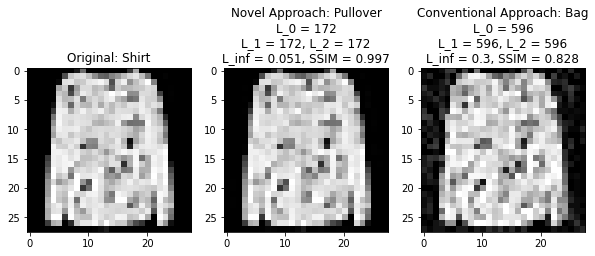

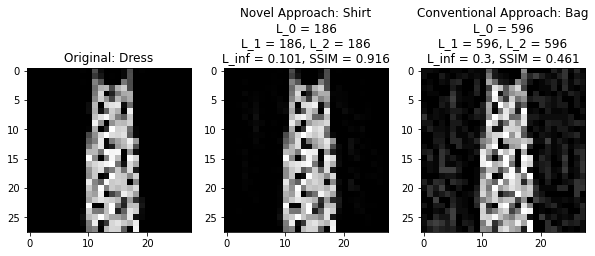

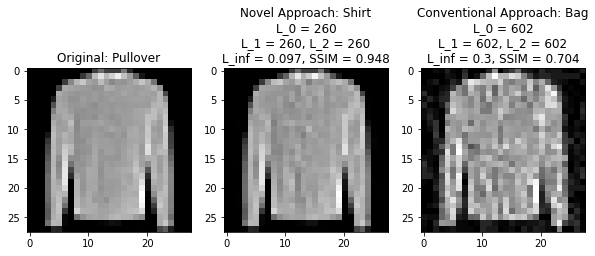

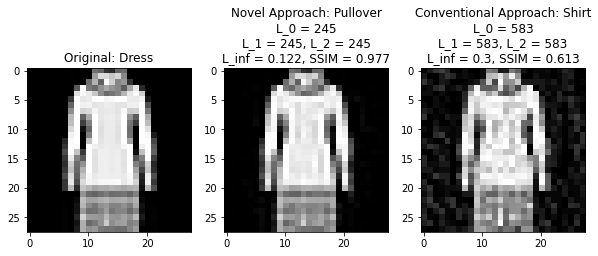

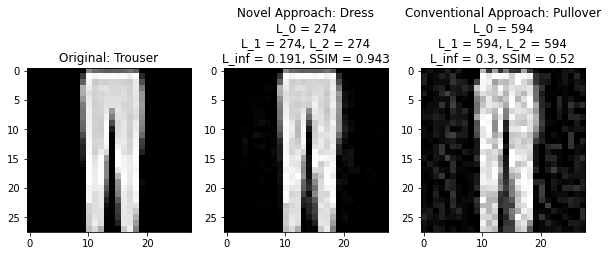

Total Image Count: 101 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.62
Total Image Count: 107 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.618
Total Image Count: 113 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.617
Total Image Count: 118 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.93 Conventional: 0.618
Total Image Count: 123 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.618
Total Image Count: 129 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.622
Total Image Count: 134 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.623
Total Image Count: 140 Success Rate:
 Novel Approach: 1.0 Conventional Approac

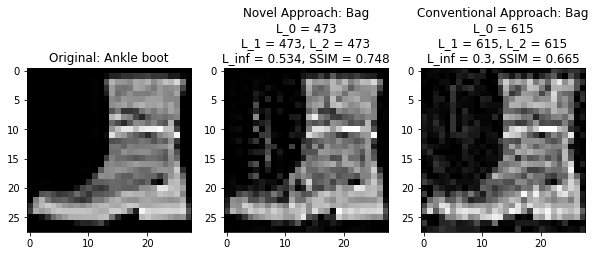

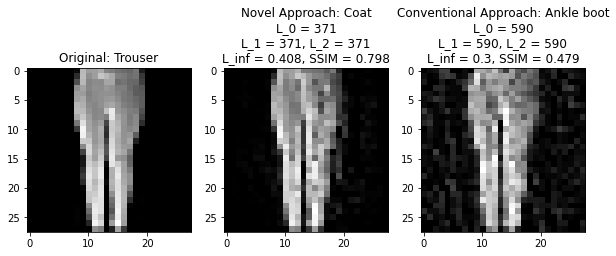

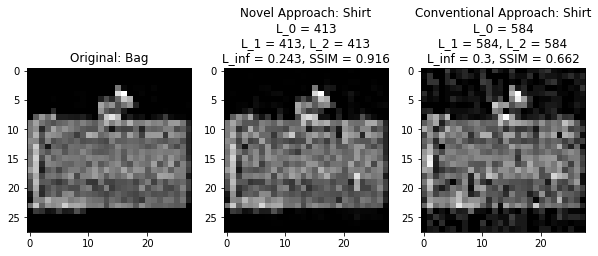

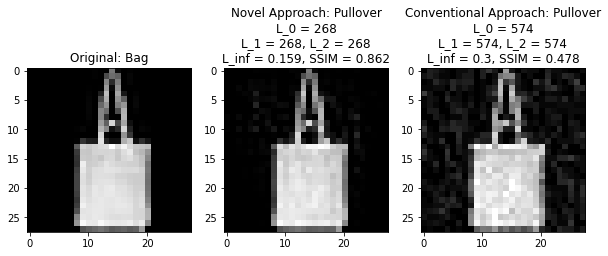

Total Image Count: 154 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.619
Total Image Count: 158 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.619
Total Image Count: 165 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.619
Total Image Count: 167 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.927 Conventional: 0.619
Total Image Count: 172 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.928 Conventional: 0.618
Total Image Count: 180 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.617
Total Image Count: 188 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.617
Total Image Count: 195 Success Rate:
 Novel Approach: 1.0 Conventional Appro

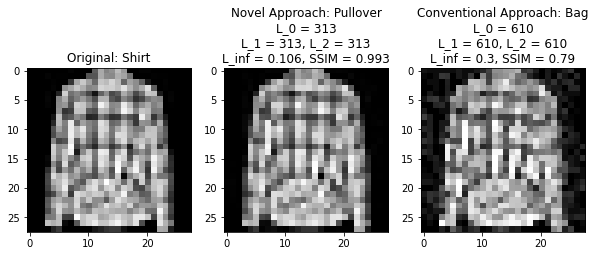

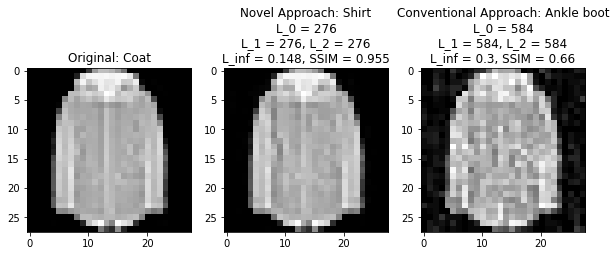

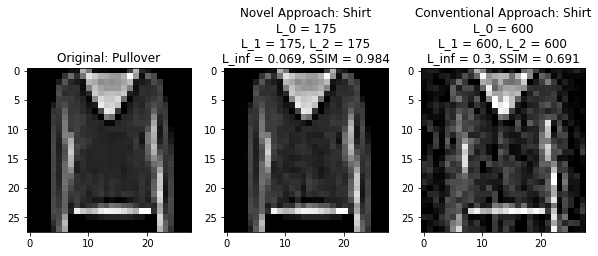

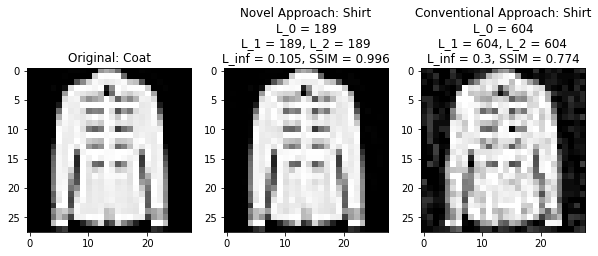

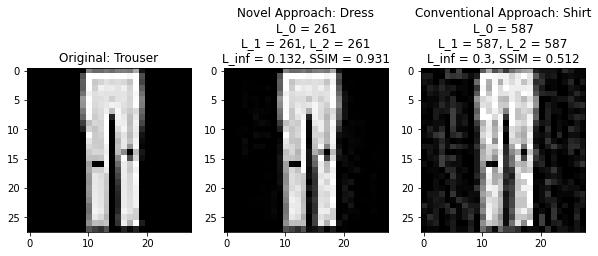

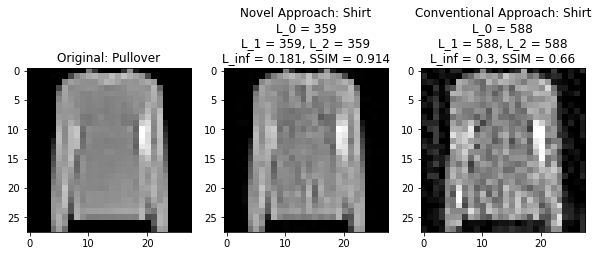

Total Image Count: 214 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.62
Total Image Count: 219 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.62
Total Image Count: 223 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.621
Total Image Count: 229 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.622
Total Image Count: 234 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.621
Total Image Count: 238 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.621
Total Image Count: 244 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.933 Conventional: 0.621
Total Image Count: 250 Success Rate:
 Novel Approach: 1.0 Conventional Approac

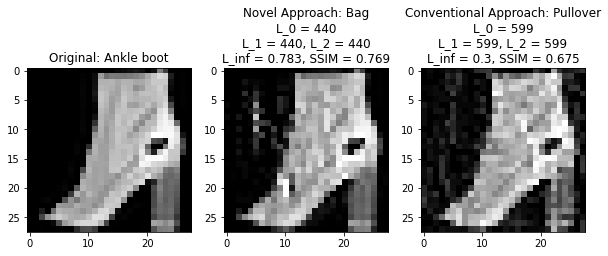

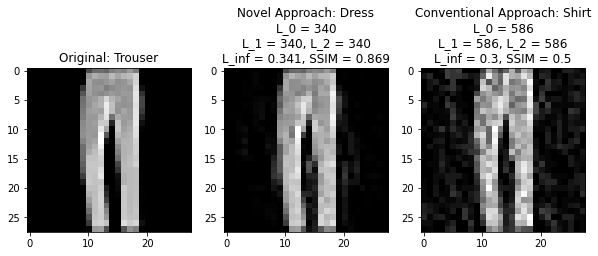

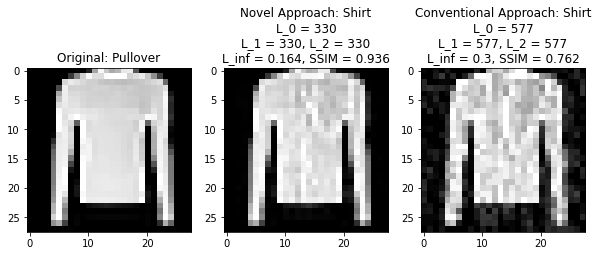

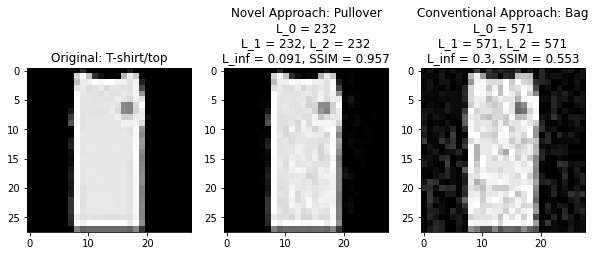

Total Image Count: 262 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.933 Conventional: 0.622
Total Image Count: 269 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.934 Conventional: 0.624
Total Image Count: 276 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.934 Conventional: 0.623
Total Image Count: 282 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.625
Total Image Count: 287 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.625
Total Image Count: 294 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.624
Total Image Count: 299 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.622
Total Image Count: 304 Success Rate:
 Novel Approach: 1.0 Conventional Appro

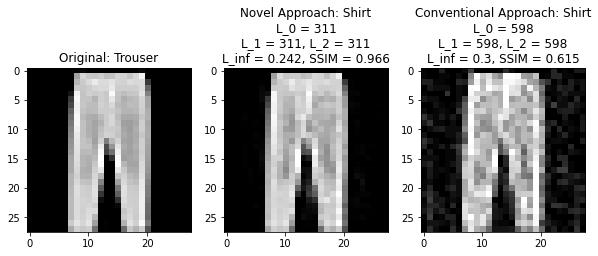

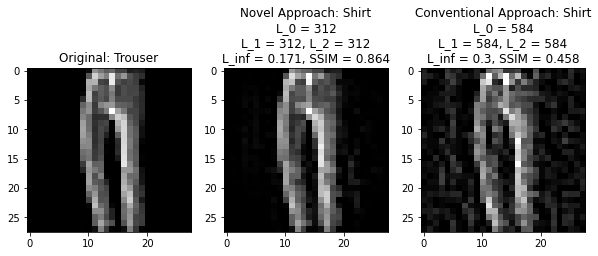

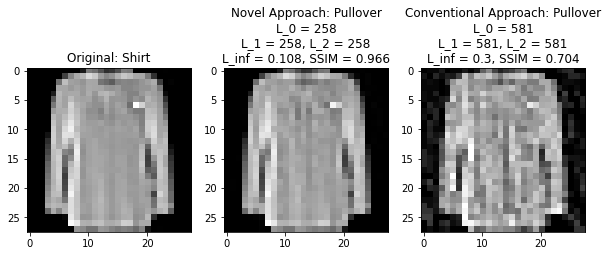

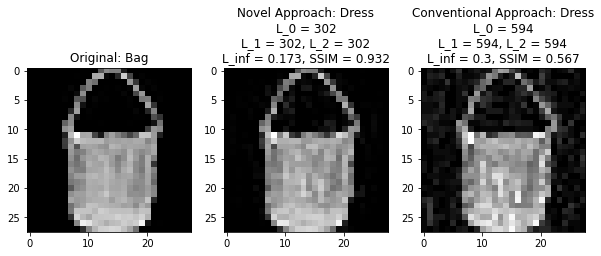

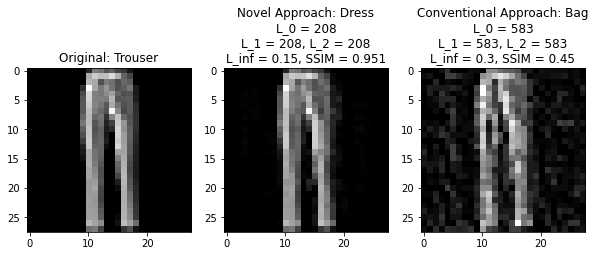

Total Image Count: 315 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.934 Conventional: 0.622
Total Image Count: 319 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.934 Conventional: 0.622
Total Image Count: 326 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.934 Conventional: 0.623
Total Image Count: 332 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.625
Total Image Count: 335 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.625
Total Image Count: 340 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.625
Total Image Count: 343 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.626
Total Image Count: 351 Success Rate:
 Novel Approach: 1.0 Conventional Appro

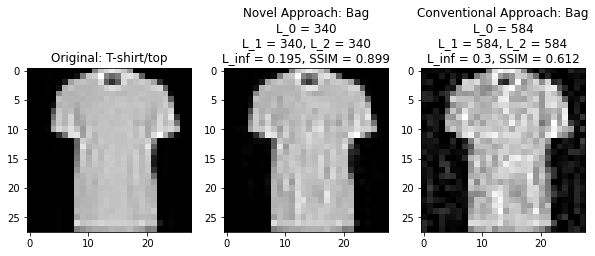

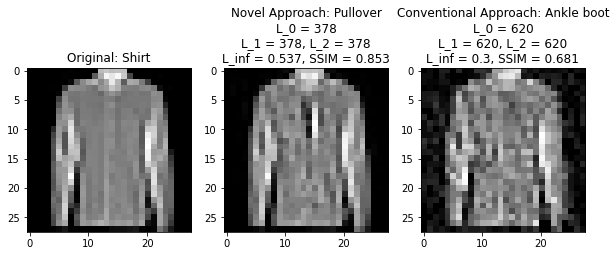

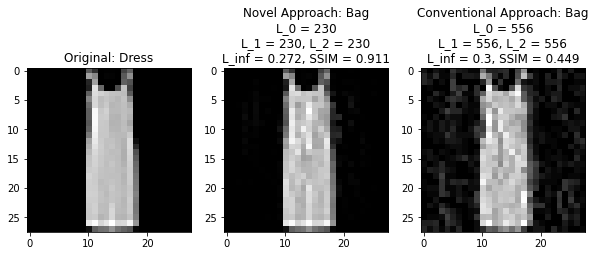

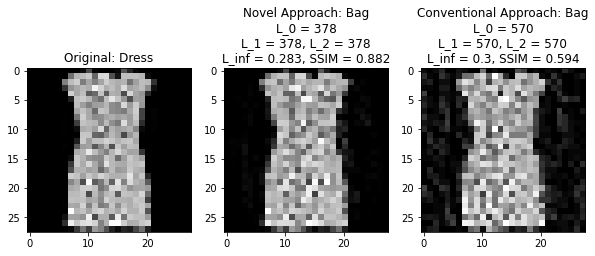

Total Image Count: 363 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.935 Conventional: 0.626
Total Image Count: 365 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.934 Conventional: 0.626
Total Image Count: 369 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.933 Conventional: 0.625
Total Image Count: 372 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.933 Conventional: 0.625
Total Image Count: 376 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.933 Conventional: 0.624
Total Image Count: 381 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.623
Total Image Count: 386 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.624
Total Image Count: 391 Success Rate:
 Novel Approach: 1.0 Conventional Appro

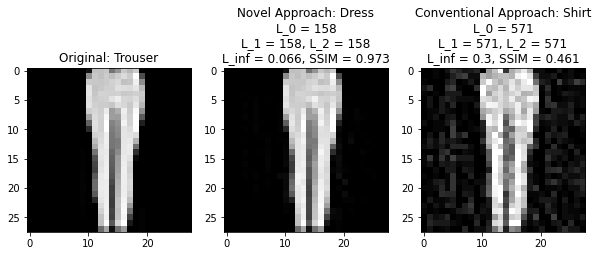

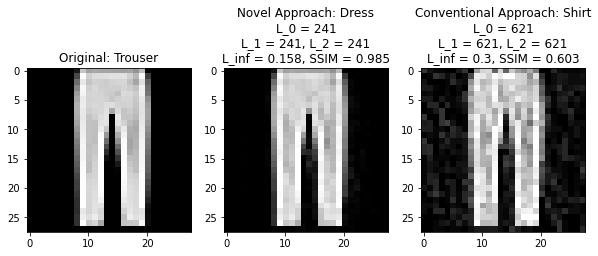

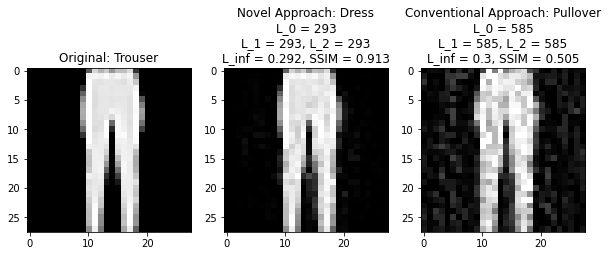

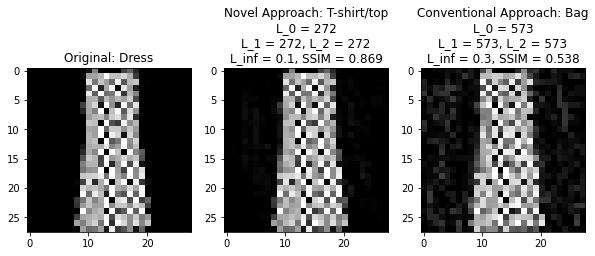

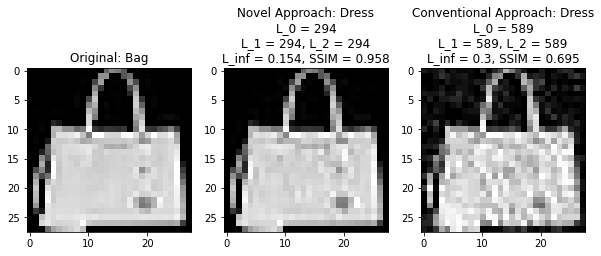

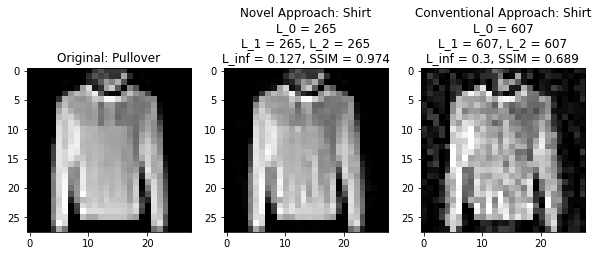

Total Image Count: 405 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.624
Total Image Count: 409 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.624
Total Image Count: 413 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.625
Total Image Count: 415 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.624
Total Image Count: 421 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.932 Conventional: 0.623
Total Image Count: 426 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.623
Total Image Count: 429 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.622
Total Image Count: 434 Success Rate:
 Novel Approach: 1.0 Conventional Appro

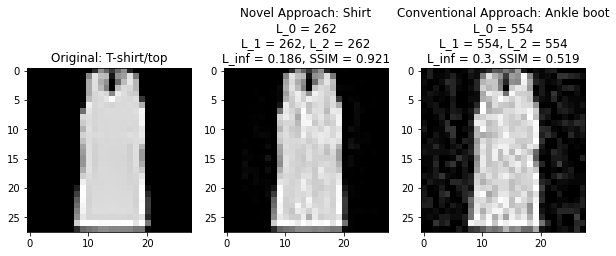

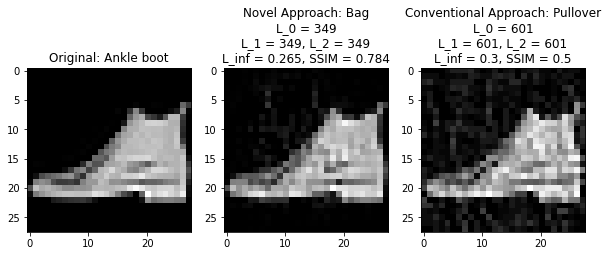

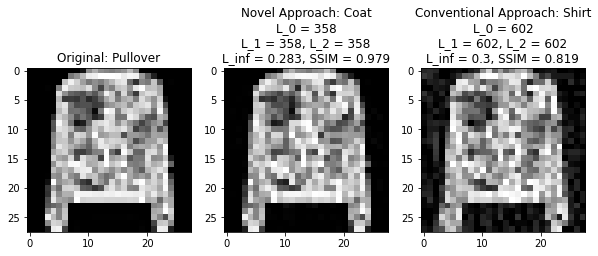

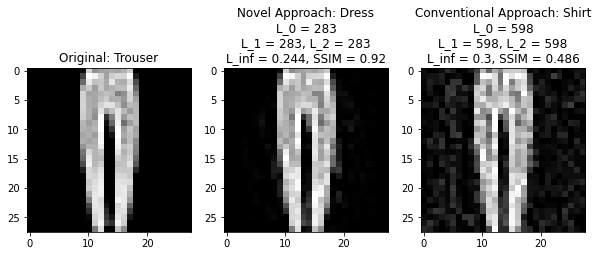

Total Image Count: 448 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.621
Total Image Count: 451 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.621
Total Image Count: 457 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.621
Total Image Count: 463 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.62
Total Image Count: 467 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.62
Total Image Count: 474 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.62
Total Image Count: 476 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.931 Conventional: 0.62
Total Image Count: 479 Success Rate:
 Novel Approach: 1.0 Conventional Approach:

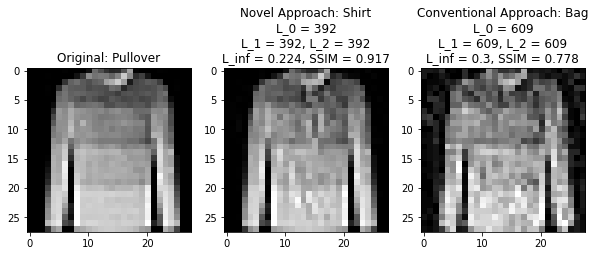

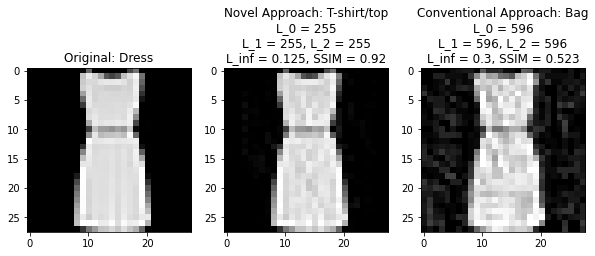

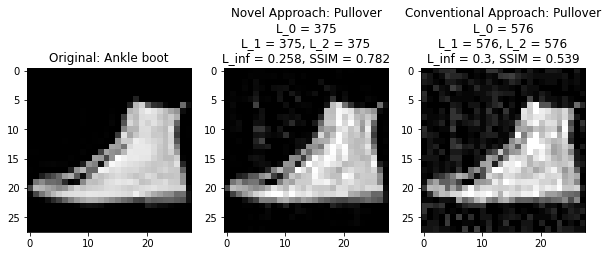

Total Image Count: 490 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Average SSIM: Novel: 0.929 Conventional: 0.619


In [14]:
# PGD TEST
# N = Novel Approach, C = Conventional Approach
model.eval()
success_N = 0
success_C = 0
SSIM_N_total = 0
SSIM_C_total = 0
total = 0
pred_suc = 0
attpre_suc = 0
batch_num = 0
for images, labels in test_loader:
    batch_num += 1
    images = images.to(device)
    labels = labels.to(device)
    outputs_N = model(images)
    _, ori_preds = torch.max(outputs_N, 1)   #original outputs
    index = np.arange(labels.size(0))
    # print(labels.size())
    index = index[ori_preds == labels]
    # print(images.size())
    images = images[index]
    labels = labels[index]

    # Novel Approach
    att_images_N, deltas = PGD_attack_MyLoss(model, images, labels, eps, step_size)
    att_outputs_N = model(att_images_N)
    _, att_preds_N = torch.max(att_outputs_N, 1)
    success_N += (labels != att_preds_N).sum().item()
    # success += (ori_preds != att_preds_N).sum().item()
    # pred_suc += (ori_preds == labels).sum().item()
    # attpre_suc += (att_preds_N == labels).sum().item()

    # Conventional Approach
    att_images_C, deltas_conv = PGD_attack_Conventional(model, images, labels, eps,step_size=0.025)
    att_outputs_C = model(att_images_C)
    _, att_preds_C = torch.max(att_outputs_C.data, 1)
    success_C += (labels != att_preds_C).sum().item()

    # Display Result
    total += labels.size(0)
    for i in range (0, images.size()[0]):
        SSIM_N = pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item()
        SSIM_C = pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_C[i].unsqueeze(0)).item()
        SSIM_N_total += SSIM_N
        SSIM_C_total += SSIM_C
        if(batch_num % 10 == 0):
            l0_N = l0(images[i], att_images_N[i])
            l0_C = l0(images[i], att_images_C[i])
            l1_N = l0(images[i], att_images_N[i])
            l1_C = l0(images[i], att_images_C[i])
            l2_N = l0(images[i], att_images_N[i])
            l2_C = l0(images[i], att_images_C[i])
            triple_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
                        torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
                        torchvision.utils.make_grid(att_images_C[i].data, normalize=True),
                        "Original: " + str(test_dataset.classes[labels[i]]),
                        "Novel Approach: " + str(test_dataset.classes[att_preds_N[i]])
                        + '\n' + "L_0 = " + str(round(l0_N, 3)) + '\n' + "L_1 = " + str(round(l1_N,3)) + ", L_2 = " + str(round(l2_N,3))
                        + '\n' + 'L_inf = ' + str(round(deltas[i],3)) + ', SSIM = ' + str(round(SSIM_N,3)),
                        "Conventional Approach: " +str(test_dataset.classes[att_preds_C[i]])
                        + '\n' + "L_0 = " + str(round(l0_C, 3)) + '\n' + "L_1 = " + str(round(l1_C,3)) + ", L_2 = " + str(round(l2_C,3))
                        + '\n' + 'L_inf = ' + str(0.3) + ', SSIM = ' + str(round(SSIM_C, 3)),
                        5 * batch_num - 4 + i)
    #     double_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
    #                     torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
    #                     "Original: " + str(train_dataset.classes[labels[i]]),
    #                     "Novel Approach: " + str(train_dataset.classes[att_preds_N[i]])
    #                     + '\n' + str(round(deltas[i],3)))
    #     print('SSIM_N = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)))
    #     print('SSIM_C = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)))
    print("Total Image Count:", total,"Success Rate:\n", 
              "Novel Approach:", success_N / total, "Conventional Approach:", success_C / total)
    print("Average SSIM: Novel:",round(SSIM_N_total/total,3), "Conventional:",round(SSIM_C_total/total,3))
    if(batch_num >=  100):
        break